In [1]:
# For linear algebra
using StaticArrays: SVector 
using LinearAlgebra
using SparseArrays: SparseMatrixCSC, sparse
# Fast Cholesky
using KoLesky 
using Plots

In [2]:
function sample_points_grid(Ω, h_in, h_bd)
    x1l = Ω[1,1]
    x1r = Ω[2,1]
    x2l = Ω[1,2]
    x2r = Ω[2,2]
    x = x1l + h_in:h_in:x1r-h_in
    y = x2l + h_in:h_in:x2r-h_in
    X_domain = reduce(hcat,[[x[i], y[j]] for i in 1:length(x) for j in 1:length(x)])

    l = length(x1l:h_bd:x1r-h_bd)
    X_boundary = vcat([x1l:h_bd:x1r-h_bd x2l*ones(l)], [x1r*ones(l) x2l:h_bd:x2r-h_bd], [x1r:-h_bd:x1l+h_bd x2r*ones(l)], [x1l*ones(l) x2r:-h_bd:x1l+h_bd])
    return X_domain, X_boundary'
end

sample_points_grid (generic function with 1 method)

In [3]:
# Measurements, kernel matrix
function get_kernel_mtx(X_domain, X_boundary, cov; d = 2)
    
    N_domain = size(X_domain,2); N_boundary = size(X_boundary,2)
    δ_coefs = 0.0
    meas_δ_bd = [KoLesky.PointMeasurement{d}(SVector{d,Float64}(X_boundary[:,i])) for i = 1:N_boundary]
    meas_δ_int = [KoLesky.PointMeasurement{d}(SVector{d,Float64}(X_domain[:,i])) for i = 1:N_domain]
    measurements = Vector{Vector{<:KoLesky.AbstractPointMeasurement}}(undef,2)
    measurements[1] = meas_δ_bd; measurements[2] = meas_δ_int;
    # Exact Theta
    sz = length(reduce(vcat,measurements))
    Theta = zeros(sz,sz)
    cov(Theta, reduce(vcat,measurements))
    return measurements, Theta
end



get_kernel_mtx (generic function with 1 method)

In [4]:
lengthscale = 0.3
cov = KoLesky.MaternCovariance5_2(lengthscale)
h_grid = 0.02
Ω = [[0,1] [0,1]]

X_domain, X_boundary = sample_points_grid(Ω,h_grid, h_grid)
N_domain = size(X_domain,2); N_boundary = size(X_boundary,2)
meas_separate_bd, Theta = get_kernel_mtx(X_domain, X_boundary, cov)
Theta

2601×2601 Matrix{Float64}:
 1.0         0.996315    0.985467    …  0.00182013  0.00167001  0.00153062
 0.996315    1.0         0.996315       0.00198884  0.00182344  0.00167001
 0.985467    0.996315    1.0            0.00217088  0.00198884  0.00182013
 0.967986    0.985467    0.996315       0.00236698  0.00216686  0.00198155
 0.944607    0.967986    0.985467       0.00257791  0.00235816  0.00215486
 0.916168    0.944607    0.967986    …  0.00280441  0.00256338  0.00234062
 0.883545    0.916168    0.944607       0.00304721  0.00278318  0.00253937
 0.847605    0.883545    0.916168       0.00330704  0.00301816  0.00275166
 0.809168    0.847605    0.883545       0.00358459  0.00326892  0.00297799
 0.768993    0.809168    0.847605       0.0038805   0.00353602  0.00321884
 0.727763    0.768993    0.809168    …  0.00419537  0.00381997  0.00347464
 0.686078    0.727763    0.768993       0.00452976  0.00412121  0.00374577
 0.644456    0.686078    0.727763       0.00488412  0.00444015  0.0040325

In [5]:
meas_notseparate_bd = reduce(vcat,meas_separate_bd)

2601-element Vector{KoLesky.PointMeasurement{2}}:
 KoLesky.PointMeasurement{2}([0.0, 0.0])
 KoLesky.PointMeasurement{2}([0.02, 0.0])
 KoLesky.PointMeasurement{2}([0.04, 0.0])
 KoLesky.PointMeasurement{2}([0.06, 0.0])
 KoLesky.PointMeasurement{2}([0.08, 0.0])
 KoLesky.PointMeasurement{2}([0.1, 0.0])
 KoLesky.PointMeasurement{2}([0.12, 0.0])
 KoLesky.PointMeasurement{2}([0.14, 0.0])
 KoLesky.PointMeasurement{2}([0.16, 0.0])
 KoLesky.PointMeasurement{2}([0.18, 0.0])
 KoLesky.PointMeasurement{2}([0.2, 0.0])
 KoLesky.PointMeasurement{2}([0.22, 0.0])
 KoLesky.PointMeasurement{2}([0.24, 0.0])
 ⋮
 KoLesky.PointMeasurement{2}([0.98, 0.76])
 KoLesky.PointMeasurement{2}([0.98, 0.78])
 KoLesky.PointMeasurement{2}([0.98, 0.8])
 KoLesky.PointMeasurement{2}([0.98, 0.82])
 KoLesky.PointMeasurement{2}([0.98, 0.84])
 KoLesky.PointMeasurement{2}([0.98, 0.86])
 KoLesky.PointMeasurement{2}([0.98, 0.88])
 KoLesky.PointMeasurement{2}([0.98, 0.9])
 KoLesky.PointMeasurement{2}([0.98, 0.92])
 KoLesky.PointMeasu

In [6]:
ρ = 3.0
k_neighbors = 1
nugget = 0.0
lambda = 1.5
alpha = 1.0

implicit_factor = KoLesky.ImplicitKLFactorization(cov, meas_notseparate_bd, ρ, k_neighbors; lambda = lambda, alpha = alpha)
P = implicit_factor.P
U_exact = inv(cholesky(Theta[P,P]).U)

2601×2601 UpperTriangular{Float64, Matrix{Float64}}:
 1.0  -0.00128403  -0.0156107  -0.0155983    …   -1.62121e-6    -3.98748e-9
  ⋅    1.0         -0.0156107  -0.0155983        -9.05782e-6    -9.36781e-6
  ⋅     ⋅           1.00024    -0.000796831      -0.0814503     -1.82183e-8
  ⋅     ⋅            ⋅          1.00024           2.01141e-9    -1.62413e-7
  ⋅     ⋅            ⋅           ⋅               -3.39432e-7     1.63247e-7
  ⋅     ⋅            ⋅           ⋅           …    3.84114e-10   -3.40213e-5
  ⋅     ⋅            ⋅           ⋅               -0.000108365    5.51953e-8
  ⋅     ⋅            ⋅           ⋅                2.18019e-8    -4.67202e-9
  ⋅     ⋅            ⋅           ⋅               -0.000677486   -4.30945e-7
  ⋅     ⋅            ⋅           ⋅               -1.7295e-7    -70.2034
  ⋅     ⋅            ⋅           ⋅           …    1.26368e-7    -1.50576e-7
  ⋅     ⋅            ⋅           ⋅                4.57862e-6     1.30137e-7
  ⋅     ⋅            ⋅           ⋅     

In [7]:
X_all = hcat(X_boundary, X_domain)

2×2601 Matrix{Float64}:
 0.0  0.02  0.04  0.06  0.08  0.1  …  0.98  0.98  0.98  0.98  0.98  0.98
 0.0  0.0   0.0   0.0   0.0   0.0     0.88  0.9   0.92  0.94  0.96  0.98

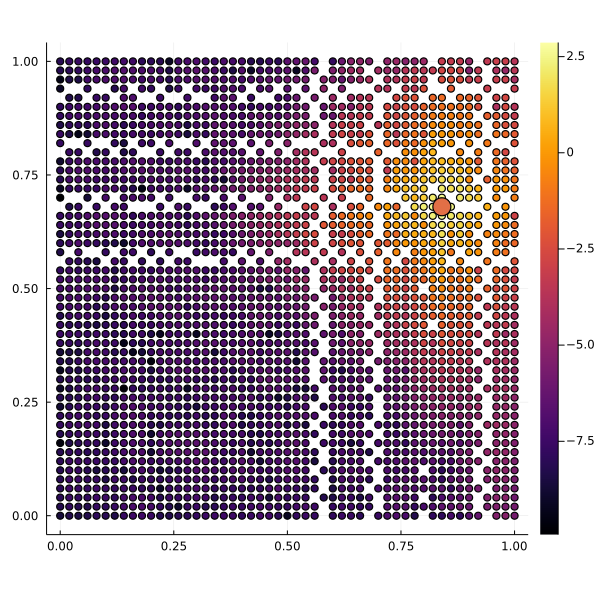

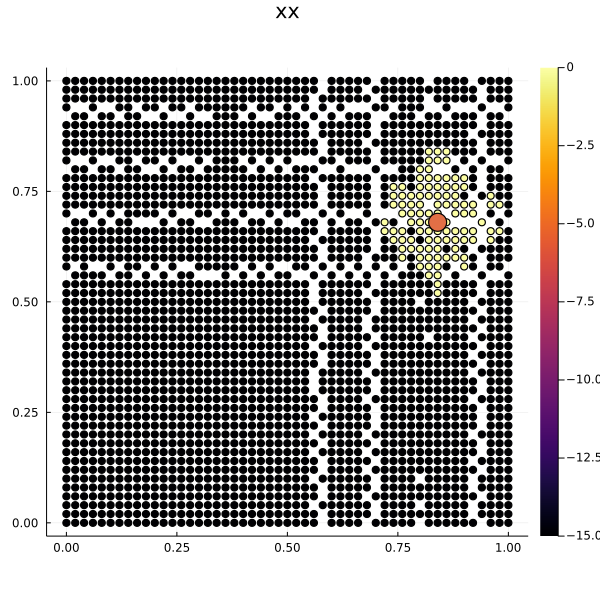

In [47]:
pts_idx = floor(Int,((1/h_grid+1)^2)*0.88)

plts = scatter(X_all[1,P[1:pts_idx]],X_all[2,P[1:pts_idx]], marker_z = log.(abs.(U_exact[1:pts_idx, pts_idx]).+1e-15)/log(10), legend = false,  colorbar = true)
scatter!([X_all[1,P[pts_idx]]],[X_all[2,P[pts_idx]]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
display(plts)

val = log.(abs.(U_exact[1:pts_idx, pts_idx]).+1e-15)/log(10)
threshold = max(val...)-3
val[val .<= threshold] .= -15
val[val .> threshold] .= 0



plts2 = scatter(X_all[1,P[1:pts_idx]],X_all[2,P[1:pts_idx]], marker_z = val, title = "xx", legend = false,  colorbar = true)
scatter!([X_all[1,P[pts_idx]]],[X_all[2,P[pts_idx]]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
display(plts2)

In [48]:
using PyPlot

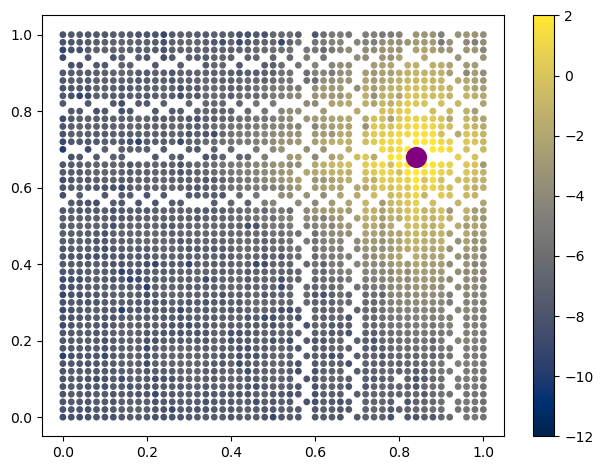

In [49]:
fig = figure("pyplot_scatterplot",figsize=(8,6))
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=false)

sm = ax.scatter(X_all[1,P[1:pts_idx]],X_all[2,P[1:pts_idx]],s=15,c=log.(abs.(U_exact[1:pts_idx, pts_idx]).+1e-15)/log(10), cmap = "cividis", vmin=-12, vmax=2, alpha = 1)
fig.colorbar(sm, ax=ax)
# ax.set_xlabel(L"x")
# ax.set_ylabel(L"y")
ax.scatter([X_all[1,P[pts_idx]]],[X_all[2,P[pts_idx]]], s=200, c="purple")
fig.tight_layout()
# fig.savefig("Diracs_80percent.pdf")

In [30]:
?PyPlot.scatter

A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2.
    Default is ``rcParams['lines.markersize'] ** 2``.

c : array-like or list of colors or color, optional
    The marker colors. Possible values:

    - A scalar or sequence of n numbers to be mapped to colors using
      *cmap* and *norm*.
    - A 2D array in which the rows are RGB or RGBA.
    - A sequence of colors of length n.
    - A single color format string.

    Note that *c* should not be a single numeric RGB or RGBA sequence
    because that is indistinguishable from an array of values to be
    colormapped. If you want to specify the same RGB or RGBA value for
    all points, use a 2D array with a single row.  Otherwise, value-
    matching will have precedence in case of a size matching with *x*
    and *y*.

    If you wish to specify a 

In [33]:
log.(abs.(U_exact[1:pts_idx, pts_idx]).+1e-15)/log(10)
X_all[1,P[1:pts_idx]]

1430-element Vector{Float64}:
 0.0
 1.0
 0.0
 1.0
 0.5
 1.0
 0.0
 0.5
 0.5
 0.76
 0.24
 0.24
 0.74
 ⋮
 0.7
 0.12
 0.66
 0.7
 0.32
 0.32
 0.32
 0.78
 0.52
 0.72
 0.34
 0.32

In [9]:
explicit_factor = KoLesky.ExplicitKLFactorization(implicit_factor; nugget = nugget)
U = copy(explicit_factor.U)
U.nzval .= 1.0
U = Matrix(U)
truncation_U = U.*U_exact
@show length((explicit_factor.U.nzval))

[multithreading] using 1 threads
length(explicit_factor.U.nzval) = 78031


78031

In [10]:
invTheta = inv(Theta[P,P]+nugget*diagm(diag(Theta[P,P])))
opnorm_invTheta = opnorm(invTheta)
@show opnorm(invTheta - Matrix(truncation_U*truncation_U'))/opnorm_invTheta
@show opnorm_invTheta

@show opnorm(invTheta - Matrix(explicit_factor.U*explicit_factor.U'))/opnorm_invTheta

opnorm(invTheta - Matrix(truncation_U * truncation_U')) / opnorm_invTheta = 0.08138197067869654
opnorm_invTheta = 3.6620258345003994e6
opnorm(invTheta - Matrix(explicit_factor.U * (explicit_factor.U)')) / opnorm_invTheta = 0.15819668022262853


0.15819668022262853

In [11]:
truncation_U_inv = inv(Matrix(truncation_U))
opnorm_Theta = opnorm(Theta[P,P])
@show opnorm(Theta[P,P] - truncation_U_inv'*truncation_U_inv)/opnorm_Theta
@show opnorm_Theta

U_inv = inv(Matrix(explicit_factor.U))
@show opnorm(Theta[P,P] - U_inv'*U_inv)/opnorm_Theta

opnorm(Theta[P, P] - truncation_U_inv' * truncation_U_inv) / opnorm_Theta = 0.36742191207432606
opnorm_Theta = 811.5467237831456
opnorm(Theta[P, P] - U_inv' * U_inv) / opnorm_Theta = 0.010529066268265663


0.010529066268265663

In [12]:
truncation_U
Matrix(explicit_factor.U)

2601×2601 Matrix{Float64}:
 1.0  -0.00128403  -0.0156107  -0.0155983    …    0.0       0.0      0.0
 0.0   1.0         -0.0156107  -0.0155983         0.0       0.0      0.0
 0.0   0.0          1.00024    -0.000796831       0.0       0.0      0.0
 0.0   0.0          0.0         1.00024           0.0       0.0      0.0
 0.0   0.0          0.0         0.0             -30.6415    0.0      0.0
 0.0   0.0          0.0         0.0          …    0.0       0.0      0.0
 0.0   0.0          0.0         0.0               0.0       0.0      0.0
 0.0   0.0          0.0         0.0               0.0       0.0      0.0
 0.0   0.0          0.0         0.0               0.0       0.0      0.0
 0.0   0.0          0.0         0.0               0.0       0.0    -65.1262
 0.0   0.0          0.0         0.0          …    0.0       0.0      0.0
 0.0   0.0          0.0         0.0               0.0       0.0      0.0
 0.0   0.0          0.0         0.0               0.0       0.0      0.0
 ⋮                   

In [13]:
# separated
ρ = 3.0
k_neighbors = 1
nugget = 0.0
lambda = 1.5
alpha = 1.0

implicit_factor2 = KoLesky.ImplicitKLFactorization(cov, meas_separate_bd, ρ, k_neighbors; lambda = lambda, alpha = alpha)
P2 = implicit_factor2.P
U_exact2 = inv(cholesky(Theta[P2,P2]).U)

2601×2601 UpperTriangular{Float64, Matrix{Float64}}:
 1.0  -0.00128403  -0.0156107  -0.0155983    …   -2.99233e-8     2.10919e-9
  ⋅    1.0         -0.0156107  -0.0155983         6.08209e-8     0.000104392
  ⋅     ⋅           1.00024    -0.000796831      -2.81853e-9     8.80468e-9
  ⋅     ⋅            ⋅          1.00024          -6.14899e-7     1.39168e-6
  ⋅     ⋅            ⋅           ⋅                2.4624e-6      0.000210826
  ⋅     ⋅            ⋅           ⋅           …   -2.60248e-8     3.49095e-8
  ⋅     ⋅            ⋅           ⋅               -5.42441e-6     8.74512e-8
  ⋅     ⋅            ⋅           ⋅               -1.02221e-7     3.49922e-7
  ⋅     ⋅            ⋅           ⋅                4.74832e-8     1.48352e-7
  ⋅     ⋅            ⋅           ⋅               -0.000312911   -9.41326e-8
  ⋅     ⋅            ⋅           ⋅           …   -3.40378e-8     2.27005e-8
  ⋅     ⋅            ⋅           ⋅                9.00704e-8     0.0120745
  ⋅     ⋅            ⋅           ⋅

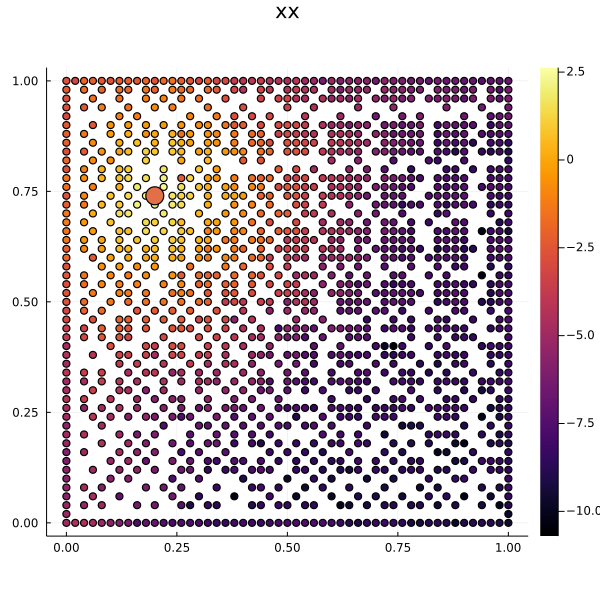

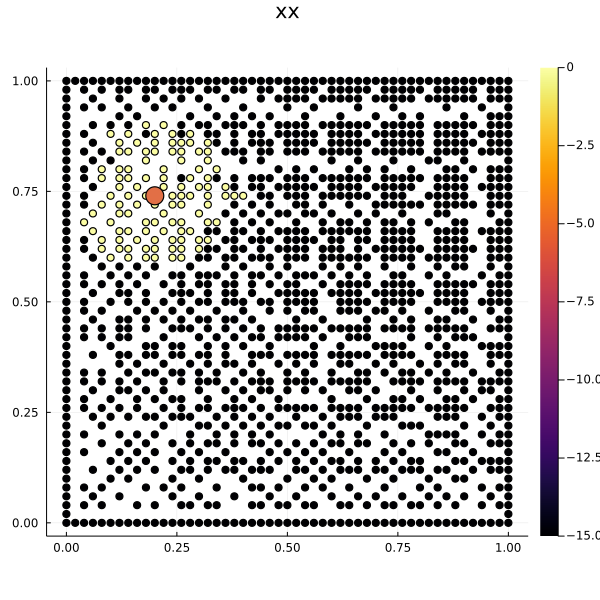

In [14]:
pts_idx = floor(Int,((1/h_grid+1)^2)*0.55)

plts = scatter(X_all[1,P2[1:pts_idx]],X_all[2,P2[1:pts_idx]], marker_z = log.(abs.(U_exact2[1:pts_idx, pts_idx]).+1e-15)/log(10), title = "xx", legend = false,  colorbar = true)
scatter!([X_all[1,P2[pts_idx]]],[X_all[2,P2[pts_idx]]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
display(plts)


val = log.(abs.(U_exact2[1:pts_idx, pts_idx]).+1e-15)/log(10)
threshold = max(val...)-3
val[val .<= threshold] .= -15
val[val .> threshold] .= 0
plts2 = scatter(X_all[1,P2[1:pts_idx]],X_all[2,P2[1:pts_idx]], marker_z = val, title = "xx", legend = false,  colorbar = true)
scatter!([X_all[1,P2[pts_idx]]],[X_all[2,P2[pts_idx]]], markersize = 10, aspect_ratio=:equal, size=(600,600), legend = false)
display(plts2)

In [15]:
explicit_factor2 = KoLesky.ExplicitKLFactorization(implicit_factor2; nugget = nugget)
U = copy(explicit_factor2.U)
U.nzval .= 1.0
U = Matrix(U)
truncation_U = U.*U_exact2
@show length((explicit_factor2.U.nzval))

[multithreading] using 1 threads
length(explicit_factor2.U.nzval) = 106671


106671

In [16]:
invTheta = inv(Theta[P2,P2]+nugget*diagm(diag(Theta[P2,P2])))
opnorm_invTheta = opnorm(invTheta)
@show opnorm(invTheta - Matrix(truncation_U*truncation_U'))/opnorm_invTheta
@show opnorm_invTheta

@show opnorm(invTheta - Matrix(explicit_factor2.U*explicit_factor2.U'))/opnorm_invTheta

opnorm(invTheta - Matrix(truncation_U * truncation_U')) / opnorm_invTheta = 0.0713150490327674
opnorm_invTheta = 3.6620258280104734e6
opnorm(invTheta - Matrix(explicit_factor2.U * (explicit_factor2.U)')) / opnorm_invTheta = 0.1854392287488403


0.1854392287488403

In [17]:
truncation_U_inv = inv(Matrix(truncation_U))
opnorm_Theta = opnorm(Theta[P2,P2])
@show opnorm(Theta[P2,P2] - truncation_U_inv'*truncation_U_inv)/opnorm_Theta
@show opnorm_Theta

U_inv = inv(Matrix(explicit_factor2.U))
@show opnorm(Theta[P2,P2] - U_inv'*U_inv)/opnorm_Theta

opnorm(Theta[P2, P2] - truncation_U_inv' * truncation_U_inv) / opnorm_Theta = 3.096773258671181
opnorm_Theta = 811.5467237831456
opnorm(Theta[P2, P2] - U_inv' * U_inv) / opnorm_Theta = 0.0310463388654677


0.0310463388654677